In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 50)
import numpy as np
import os
from tqdm.notebook import tqdm
from data_processing.GameFeaturesGenerator import GameFeaturesGenerator
from data_processing.TournamentDataProcessor import TournamentDataProcessor
from data_processing.LeaguesDataProcessor import LeaguesDataProcessor
from data_processing.utils.download_functions import *
from copy import deepcopy
os.chdir('esports-data')
os.listdir()

['2021_raw_game_data',
 '2022_raw_game_data',
 'catboost_info',
 'leagues.json',
 'mapping_data.json',
 'players.json',
 'teams.json',
 'tournaments.json']

In [2]:
# Read in teams data
with open("teams.json", "r") as json_file:
   teams_data = json.load(json_file)

team_df = []
for team in teams_data:
    team_df.append({'team_id': team['team_id'], 'team_name': team['name']})
    
team_df = pd.DataFrame(team_df)

In [3]:
# Get all file names from '2021_raw_game_data'
file_names = os.listdir('2021_raw_game_data')

# Get the unique tournament names by stripping out '_game_rows.csv' and '_tournament_rows.csv'
unique_tournament_names = [file_name.split('_game_rows.csv')[0] for file_name in file_names]
unique_tournament_names = [x.replace('_tournament_rows.csv', '') for x in unique_tournament_names]
unique_tournament_names = list(set(unique_tournament_names))

In [4]:
 # ['League_TFT Rising Legends', 'League_MSI', 'League_Worlds', 'League_All-Star Event'] 

In [5]:
# Aggregate all the game rows into one dataframe, start with an empty dataframe and append onto it to save memory
tournament_rows = pd.DataFrame()
for tournament_name in tqdm(unique_tournament_names):
    df_tmp = pd.read_csv('2021_raw_game_data/' + tournament_name + '_tournament_rows.csv')
    # Add a column to indicate the tournament name
    df_tmp['tournament_name'] = tournament_name
    tournament_rows = pd.concat([tournament_rows, df_tmp])
tournament_rows.shape

game_rows = pd.DataFrame()
for tournament_name in tqdm(unique_tournament_names):
    df_tmp = pd.read_csv('2021_raw_game_data/' + tournament_name + '_game_rows.csv', index_col=0)
    # Add a column to indicate the tournament name
    df_tmp['tournament_name'] = tournament_name
    game_rows = pd.concat([game_rows, df_tmp])
game_rows.shape

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

(9574, 1243)

In [6]:
non_game_features = ['platformGameId', 'esportsGameId', 'team_id', 'start_time', 'tournament_name']
league_indicators_to_drop = ['League_TFT Rising Legends', 'League_All-Star Event', 'League_MSI', 'League_Worlds', 'League_EMEA Masters']
league_indicators = [x for x in game_rows.columns if 'League_' in x]
league_indicators = [x for x in league_indicators if x not in league_indicators_to_drop]
game_rows = game_rows.drop(columns=league_indicators_to_drop, axis=1)


# Keep this if we want to analyze specific tournaments (e.g. MSI and Worlds) or if we want to upweight/downweight certain tournaments 
# game_rows = game_rows.drop(columns=['tournament_name'], axis=1)  

game_features = [x for x in game_rows.columns if x not in non_game_features + league_indicators]
all_team_ids = np.unique(game_rows['team_id'])
print(len(all_team_ids))

240


In [7]:
"""
1. Sort the game_rows by team_id and start_time 
2. Create features for each team by averaging stats of the last 5 games that they played (or the most recent statistics if possible, with a "num_prev_games) column
    This yields a row of data where the features are the average of the last 5 games that the team played BEFORE the game of ['platformGameId', 'esportsGameId', 'team_id', 'start_time']
    We also need to drop the first row where we don't have any data to average over
3. Mark the last row of each team's data as the last game
    This is so that we can use this to predict the next game
3. Later join to the reg_season_games data for training the model 
4. Use the trained model to predict on the playoff_games data for testing 
"""

processed_game_data = []
for team in tqdm(all_team_ids):
    team_data = game_rows[game_rows['team_id']==team].reset_index()
    team_data = team_data.sort_values(by=['start_time'])
    team_data['num_prev_games'] = np.arange(len(team_data))
    # First lag by 1 game so that the current game is not included in the average. Then take the mean as the trailing average 
    team_data_features = team_data[game_features].shift(1).rolling(window=20, min_periods=1).mean()
    team_data[game_features] = team_data_features
    # Drop rows where num_prev_games == 0 as this indicates that it's the team's first game 
    team_data = team_data[team_data['num_prev_games']!=0]
    # Add one more column to indicate if the row is the last of the team's games
    # last_game_indicator_col = pd.DataFrame({'last_game_ind': team_data['num_prev_games']==team_data['num_prev_games'].max()})
    # team_data = pd.concat([team_data, last_game_indicator_col], axis=1)

    # Determine the team's primary league
    team_league = team_data[league_indicators].mean(axis=0).idxmax()
    # check if there are any rows where the team does not have a league_indicator (i.e., np.sum(team_data[league_indicators]) == 0) and if so, mark the team_league as 1 for those rows
    # This happens when a team plays in international tournaments 
    team_data.loc[np.sum(team_data[league_indicators], axis=1)==0, team_league] = 1

    # update the processed_game_data with the new league_indicator values
    processed_game_data.append(team_data)

processed_game_data = pd.concat(processed_game_data)
processed_game_data.drop('index', axis=1, inplace=True)
print(len(processed_game_data))

  0%|          | 0/240 [00:00<?, ?it/s]

9334


In [8]:
# Maintain a manual dictionary of team_id to league_indicator
# Loop through this and mark the league_indicator for each team_id as =1 for the rows where the team_id is present
league_indicator_dict = {
    '98767991892579754': 'League_LPL',  # RNG
    '104367068120825486': 'League_PCS',  # PSG Talon
    '98767991882270868': 'League_LPL',  # EDG
    '99566404850008779': 'League_LPL',  # LNG
    '99566404855553726': 'League_LPL',  # FPX
}
for team_id, league_indicator in league_indicator_dict.items():
    processed_game_data.loc[processed_game_data['team_id']==team_id, league_indicator] = 1

In [9]:
# Create two additional features related to the esport league
# If the team is an LPL or LCK team, mark indicator 'eliteLeague' as 1
# If the team is an LEC, LCS, LPL, or LCK team, mark indicator 'majorLeague' as 1
processed_game_data['eliteLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1)
processed_game_data['majorLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1) | \
                                     (processed_game_data['League_LCS'] == 1) | (processed_game_data['League_LEC'] == 1)

C:\Users\brian\AppData\Local\Temp\ipykernel_41976\1173558467.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_game_data['eliteLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1)
C:\Users\brian\AppData\Local\Temp\ipykernel_41976\1173558467.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_game_data['majorLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1) | \


In [10]:
# Check that the one-hot encoding worked correctly
if (np.sum(processed_game_data[league_indicators], axis=1) == 1).all():
    # Convert the league_indicator one-hot encoded columns to categorical variables
    for league in [x.replace('League_', '') for x in league_indicators]:
        processed_game_data['League_' + league] = processed_game_data['League_' + league].apply(lambda x: league if x==1 else '')
    # Combine it into a single column
    processed_game_data['eSportLeague'] = processed_game_data[league_indicators].apply(lambda x: ''.join(x), axis=1)
    processed_game_data = processed_game_data.drop(columns=league_indicators, axis=1)
    # Convert it to a categorical variable
    processed_game_data['eSportLeague'] = processed_game_data['eSportLeague'].astype('category')
else:
    raise ValueError('One-hot encoding of league_indicators did not work correctly')

C:\Users\brian\AppData\Local\Temp\ipykernel_41976\276814191.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_game_data['eSportLeague'] = processed_game_data[league_indicators].apply(lambda x: ''.join(x), axis=1)


In [11]:
valid_games = tournament_rows.merge(processed_game_data[['esportsGameId', 'team_id']], how='inner', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'], 
                                    suffixes=['_to_drop','_to_drop'])
valid_games = valid_games.merge(processed_game_data[['esportsGameId', 'team_id']], how='inner', 
                                    left_on=['esportsGameId', 'team_id_2'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])
valid_games.drop([x for x in valid_games.columns if '_to_drop' in x], axis=1, inplace=True)

In [12]:
# Merge processed_game_data with tournament_rows for team 1
team_1_data = valid_games.merge(processed_game_data, how='inner', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])

# Merge processed_game_data with tournament_rows for team 2
team_2_data = valid_games.merge(processed_game_data, how='inner', 
                                    left_on=['esportsGameId', 'team_id_2'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])

In [13]:
team_1_data.iloc[0]

match_id                             105596516632250436
esportsGameId                        105596516632250437
league                                 Hitpoint Masters
team_id_1                            105593129376630217
outcome_1                                             0
                                       ...             
tournament_name_to_drop    hitpoint_masters_spring_2021
num_prev_games                                        1
eliteLeague                                       False
majorLeague                                       False
eSportLeague                           Hitpoint Masters
Name: 0, Length: 1216, dtype: object

In [14]:
# Calculate the difference between the two teams for esportsGameId and for each feature
check_esportsGameId = np.all(team_1_data['esportsGameId'] == team_2_data['esportsGameId'])
check_team1_id = np.all(team_1_data['team_id_1'] == team_2_data['team_id_1'])
check_team2_id = np.all(team_1_data['team_id_2'] == team_2_data['team_id_2'])

if check_esportsGameId and check_team1_id and check_team2_id:
    # Calculate the difference between the two teams for each feature
    difference_data = team_1_data[game_features].subtract(team_2_data[game_features])
else:
    raise Exception('esportsGameId is not the same for the two teams')

# Add the difference data to the tournament_rows dataframe as well as the league data for each team
training_data = deepcopy(valid_games)
training_data = pd.concat([training_data.reset_index(), difference_data], axis=1)
training_data['eSportsLeague_1'] = team_1_data['eSportLeague']
training_data['eSportsLeague_2'] = team_2_data['eSportLeague']
training_data['eliteLeague_1'] = team_1_data['eliteLeague']
training_data['eliteLeague_2'] = team_2_data['eliteLeague']
training_data['majorLeague_1'] = team_1_data['majorLeague']
training_data['majorLeague_2'] = team_2_data['majorLeague']

# Drop the columns that were used for joining (have '_to_drop' suffix). 
training_data.drop([x for x in training_data.columns if '_to_drop' in x] + ['index'], axis=1, inplace=True)

# drop the games where the outcome is NaN, those games are when one team has not had any games yet
training_data.dropna(subset=['outcome'], inplace=True)

del team_1_data, team_2_data, difference_data

C:\Users\brian\AppData\Local\Temp\ipykernel_41976\2945610770.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  training_data['eSportsLeague_1'] = team_1_data['eSportLeague']
C:\Users\brian\AppData\Local\Temp\ipykernel_41976\2945610770.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  training_data['eSportsLeague_2'] = team_2_data['eSportLeague']
C:\Users\brian\AppData\Local\Temp\ipykernel_41976\2945610770.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [54]:
# Do catboost on the training data
from catboost import CatBoostClassifier
from catboost.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV

target_col = 'outcome_1'
## At this point could assign row weights based on 'tournament_name' column to upweight/downweight certain tournaments
X = training_data.drop(['match_id', 'esportsGameId', 'league', 'team_id_1', 'outcome_1', 'team_id_2', 'outcome_2'], axis=1)
y = training_data[target_col]

# Split into train/val/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=20)

# Get all indices where X_train['tournment_name'] contains ['worlds', 'msi'] 
international_ix_train = X_train['tournament_name'].str.contains('worlds|msi')
international_ix_test = X_test['tournament_name'].str.contains('worlds|msi')

# Create a weight vector where the international games are weighted 2x
weights_train = np.ones(len(X_train))
weights_train[international_ix_train] = 1

X_train = X_train.drop('tournament_name', axis=1)
X_val = X_val.drop('tournament_name', axis=1)
X_test = X_test.drop('tournament_name', axis=1)

In [60]:
model.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 1000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Ordered',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '0:1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_nor

In [61]:
# Hyperparameter tuning

import optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [10, 15, 25, 50, 100, 200]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 30),
        "random_strength": trial.suggest_categorical("random_strength", [0.5, 1, 1.5, 2])
    }

    model = CatBoostClassifier(**params, cat_features=['eSportsLeague_1', 'eSportsLeague_2'], task_type="GPU", devices='0:1', silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2023-09-27 21:27:31,811] A new study created in memory with name: no-name-0f1d77f4-209e-4064-a41a-05065d229bca
[I 2023-09-27 21:27:37,635] Trial 0 finished with value: 0.5833333333333334 and parameters: {'learning_rate': 0.09198055423088969, 'depth': 8, 'min_data_in_leaf': 90, 'l2_leaf_reg': 11, 'random_strength': 1}. Best is trial 0 with value: 0.5833333333333334.
[I 2023-09-27 21:27:38,925] Trial 1 finished with value: 0.6129032258064516 and parameters: {'learning_rate': 0.024797001627907406, 'depth': 5, 'min_data_in_leaf': 94, 'l2_leaf_reg': 9, 'random_strength': 1.5}. Best is trial 1 with value: 0.6129032258064516.
[I 2023-09-27 21:27:40,134] Trial 2 finished with value: 0.5967741935483871 and parameters: {'learning_rate': 0.07283005706213803, 'depth': 3, 'min_data_in_leaf': 63, 'l2_leaf_reg': 29, 'random_strength': 1.5}. Best is trial 1 with value: 0.6129032258064516.
[I 2023-09-27 21:27:41,349] Trial 3 finished with value: 0.5940860215053764 and parameters: {'learning_rate': 0

In [64]:
# Print the best parameters and fit a new model on the data based on it
print(study.best_params)
model = CatBoostClassifier(**study.best_params, cat_features=['eSportsLeague_1', 'eSportsLeague_2'], task_type="GPU", devices='0:1', silent=True)
model.fit(X_train, y_train)

{'learning_rate': 0.0022814225041343705, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 17, 'random_strength': 0.5}


In [65]:
yhat_train_model = np.round(model.predict(X_train))
yhat_train_base = (X_train['outcome'] >= 0)

yhat_test_model = np.round(model.predict(X_test))
yhat_test_base = (X_test['outcome'] >= 0)

In [66]:
 # TRAINING DATA
print("TRAINING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_train, yhat_train_model)}")
print(f"Accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_model[international_ix_train])}")
print(f"Accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_model[~international_ix_train])}")

print()

# Evaluate the accuracy for the baseline
print(f"Baseline accuracy overall: {accuracy_score(y_train, yhat_train_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_base[international_ix_train])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_base[~international_ix_train])}")

# TESTING DATA 
print("\n TESTING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_test, yhat_test_model)}")
print(f"Accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_model[international_ix_test])}")
print(f"Accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_model[~international_ix_test])}")

print()

# Evaluate the accuracy for the baseline 
print(f"Baseline accuracy overall: {accuracy_score(y_test, yhat_test_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_base[international_ix_test])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_base[~international_ix_test])}")

TRAINING DATA
Accuracy overall: 0.694677033492823
Accuracy international: 0.6783216783216783
Accuracy domestic: 0.6954076850984068

Baseline accuracy overall: 0.5681818181818182
Baseline accuracy international: 0.5874125874125874
Baseline accuracy domestic: 0.5673227116526086

 TESTING DATA
Accuracy overall: 0.5705059203444564
Accuracy international: 0.7666666666666667
Accuracy domestic: 0.5639599555061179

Baseline accuracy overall: 0.5618945102260495
Baseline accuracy international: 0.7333333333333333
Baseline accuracy domestic: 0.5561735261401557


In [67]:
# Check the feature importance of the model
pd.DataFrame({x: y for x, y in zip(X_train.columns, model.get_feature_importance())}, index = [0]).T.sort_values(by=0, ascending=False)

,0
team_share_of_VISION_SCORE_at_game_end,6.051196
team_share_of_totalGold_at_20,5.442366
bot_xp_per_min_diff_at_20,1.898760
jungle_gold_spent_at_14,1.876181
top_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_at_game_end,1.558688
...,...
top_damage_to_champions_per_min_at_30,0.000000
support_trade_efficiency_at_14,0.000000
jungle_trade_efficiency_at_30,0.000000
top_damage_to_champions_per_min_at_14,0.000000


In [41]:
# Get shapley values for the first prediction just to test the functionality 
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [71]:
shap_explainer = fasttreeshap.TreeExplainer(model, algorithm = "v1", n_jobs = -1)
shap_values = shap_explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


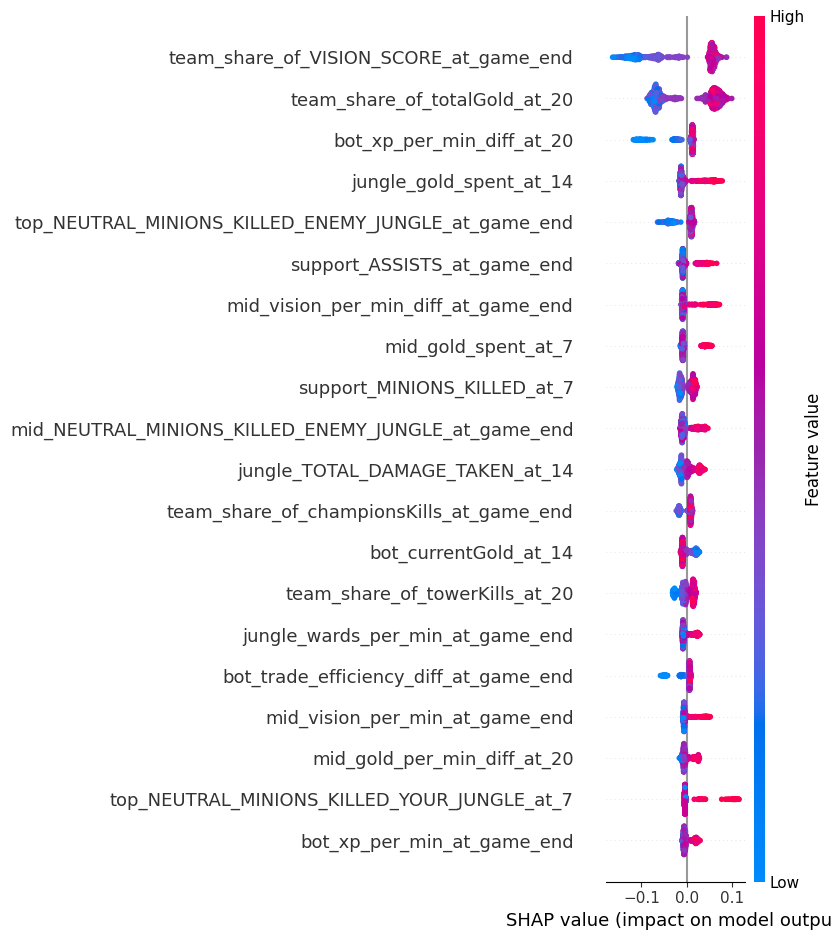

In [72]:
shap.summary_plot(shap_values, X_test)

In [73]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


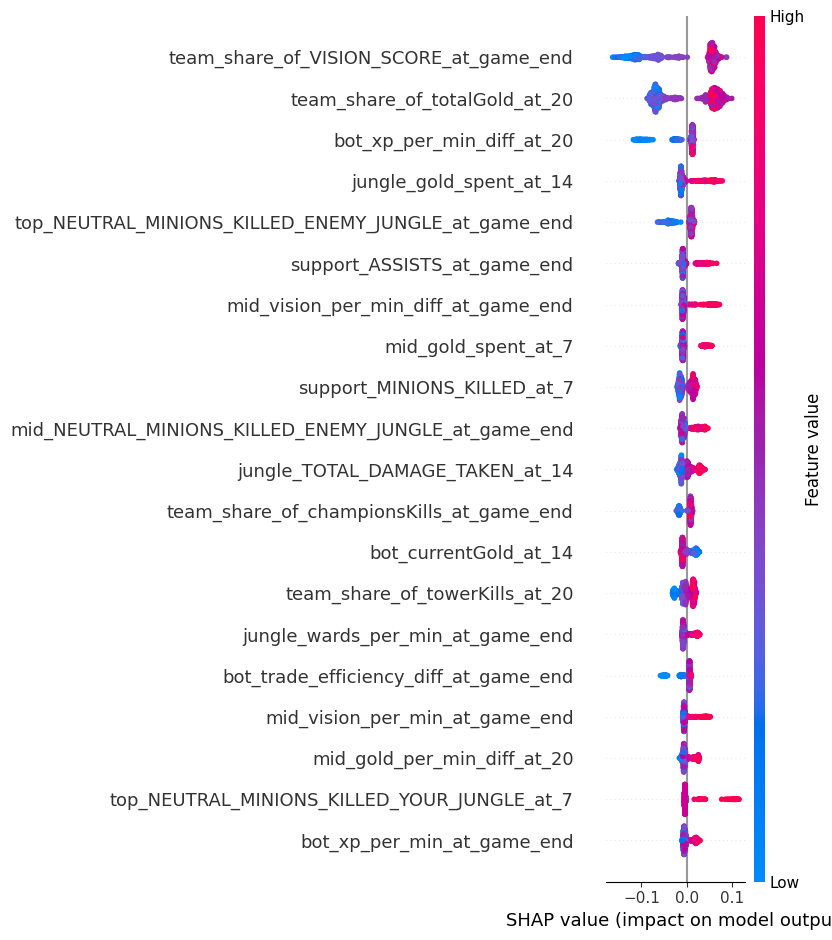

In [74]:
shap.summary_plot(shap_values, X_test)

In [59]:
# LPL has issues in Worlds and MSI because they don't show up in the data until 2023. We have to manually detect and relabel them.
# Do this by filtering to rows where tournament name is MSI or Worlds, and get teams where the sum of the league indicators is 0 (i.e. they haven't played anywhere prior)
LPL_teams = []

league_colnames = [x for x in processed_game_data.columns if 'League' in x]
msi_rows = processed_game_data[processed_game_data['tournament_name']=='worlds_2021'][non_game_features + league_indicators]
msi_rows['team_id'] = msi_rows['team_id'].astype('str')
# join msi rows with the team_name
msi_rows = msi_rows.merge(team_df, on='team_id', how='left')
msi_rows[msi_rows[league_indicators].sum(axis=1) == 1][['team_id', 'team_name']]

,team_id,team_name
38,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
39,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
40,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
41,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
42,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
43,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
44,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
45,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
46,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
47,98767991882270868,SHANGHAI EDWARD GAMING HYCAN
